In [156]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
from skimage.color import rgb2gray
import skimage.transform,skimage.filters
from scipy.sparse.linalg import eigsh
from skimage import color
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage import io

In [157]:
def NCut_UsingBrightness(image,operation):
  grayscale = rgb2gray(image)
  grayscale_1=skimage.transform.rescale(grayscale,0.1)
  plt.imshow(grayscale_1)
  img=grayscale_1.reshape(-1)
  coordinate_grid = np.array(np.meshgrid(range(0, img.shape[0]),range(0, img.shape[0]),indexing='ij'))
  m_n_array = np.array([coordinate_grid[0].ravel(), coordinate_grid[1].ravel()])
  m_array, n_array = m_n_array[0], m_n_array[1]
  W=np.exp(-(img[m_array]-img[n_array])**2/2)
  W=W.reshape(img.shape[0],img.shape[0])
  D=np.zeros((img.shape[0],img.shape[0]))
  for i in range(img.shape[0]):
    D[i,i]=np.sum(W[i,:])

  A=D-W
  w0, v0 = eigsh(A, k=3,which='SA')
  op_image = v0[:,2].reshape(grayscale_1.shape[0], grayscale_1.shape[1])
  plt.imshow(op_image>0, cmap='gray')
  plt.title(f'{operation}')
  plt.show()

  return



In [158]:
def NCut_UsingBrightnessThreeSeg(image,operation):
  image_rescaled = skimage.transform.rescale(np.array(image), 0.05)
  if image_rescaled.shape[-1] == 1:
      image_rescaled = np.repeat(image_rescaled, 3, axis=-1)
  lab_image = color.rgb2lab(image_rescaled)
  l_channel = lab_image[:, :, 0]
  im = l_channel.reshape(-1)

  coordinate_grid = np.array(np.meshgrid(range(0, im.shape[0]), range(0, im.shape[0]), indexing='ij'))
  m_n_array = np.array([coordinate_grid[0].ravel(), coordinate_grid[1].ravel()])
  m_array, n_array = m_n_array[0], m_n_array[1]

  W = np.exp(-(im[m_array] - im[n_array]) ** 2 / 2)
  W = W.reshape(im.shape[0], im.shape[0])

  D = np.zeros((im.shape[0], im.shape[0]))
  for i in range(im.shape[0]):
      D[i, i] = np.sum(W[i, :])

  # Laplacian matrix A
  A = D - W

  # Compute eigenvectors and eigenvalues
  w0, v0 = eigsh(A, k=3, which='SA', maxiter=10000)


    # Assuming v0 is the array of eigenvectors
  third_eigenvector = v0[:, 2].reshape(l_channel.shape[0], l_channel.shape[1])

  # Set thresholds for segmentation
  min_value = np.min(third_eigenvector)
  max_value = np.max(third_eigenvector)
  lower_threshold = min_value + 0.2 * (max_value - min_value)
  upper_threshold = min_value + 0.4 * (max_value - min_value)

  w0, v0 = np.linalg.eig(A)


    # Resize third_eigenvector to match the dimensions of the original image
  original_image_shape = image.shape[:2]  # Use shape to get dimensions (width, height)
  third_eigenvector_resized = resize(third_eigenvector, original_image_shape, mode='reflect', anti_aliasing=True)
    # Create a canvas for segmented image
  segmented_image = np.zeros_like(image)
  segmented_image.shape

    # Assign colors to segments based on the thresholded eigenvector
  segmented_image[third_eigenvector_resized > upper_threshold] = [255, 165, 0]  # Red for segment 1
  segmented_image[(third_eigenvector_resized >= lower_threshold) & (third_eigenvector_resized <= upper_threshold)] = [128, 0, 128]  # Green for segment 2
  segmented_image[third_eigenvector_resized < lower_threshold] = [0, 255,255 ]  # Blue for segment 3

  # Display the segmented image
  plt.imshow(segmented_image)
  plt.title(f'{operation}')
  plt.show()

In [159]:
def NCut_UsingDistance(image,operation):
  grayscale = rgb2gray(image)
  grayscale_1=skimage.transform.rescale(grayscale,0.03)
  plt.imshow(grayscale_1)
  img=grayscale_1.reshape(-1)
  coordinate_grid = np.array(np.meshgrid(range(0, img.shape[0]),range(0, img.shape[0]),indexing='ij'))
  m_n_array = np.array([coordinate_grid[0].ravel(), coordinate_grid[1].ravel()])
  m_array, n_array = m_n_array[0], m_n_array[1]
  W = np.exp(-(m_array - n_array) ** 2 / 2)
  W = W.reshape(img.shape[0], img.shape[0])
  D=np.zeros((img.shape[0],img.shape[0]))
  for i in range(img.shape[0]):
    D[i,i]=np.sum(W[i,:])

  A=D-W
  w0, v0 = eigsh(A, k=3,which='SA')
  op_image = v0[:,2].reshape(grayscale_1.shape[0], grayscale_1.shape[1])
  plt.imshow(op_image>0, cmap='gray')
  plt.title(f'{operation}')
  plt.show()

  return

In [160]:
def NCut_UsingDistanceThreeSeg(image,operation):
    # Assuming image is your RGB image
  image_rescaled = skimage.transform.rescale(np.array(image), 0.05)

  # Ensure the image has three channels
  if image_rescaled.shape[-1] == 1:
      image_rescaled = np.repeat(image_rescaled, 3, axis=-1)

  # Convert RGB to Lab color space
  lab_image = color.rgb2lab(image_rescaled)

  # Extract L channel (luminance) for spectral clustering
  l_channel = lab_image[:, :, 0]

  # Reshape L channel into a 1D array
  im = l_channel.reshape(-1)

  # Create a coordinate grid for the image
  coordinate_grid = np.array(np.meshgrid(range(0, im.shape[0]), range(0, im.shape[0]), indexing='ij'))
  m_n_array = np.array([coordinate_grid[0].ravel(), coordinate_grid[1].ravel()])
  m_array, n_array = m_n_array[0], m_n_array[1]

  # Compute pairwise affinity matrix W based on color information
  W = np.exp(-(m_array - n_array) ** 2 / 2)
  W = W.reshape(im.shape[0], im.shape[0])

  # Degree matrix D
  D = np.zeros((im.shape[0], im.shape[0]))
  for i in range(im.shape[0]):
      D[i, i] = np.sum(W[i, :])

  # Laplacian matrix A
  A = D - W

  # Compute eigenvectors and eigenvalues
  w0, v0 = eigsh(A, k=3, which='SA',maxiter=10000)

    # Assuming v0 is the array of eigenvectors
  third_eigenvector = v0[:, 2].reshape(l_channel.shape[0], l_channel.shape[1])

  # Set thresholds for segmentation
  min_value = np.min(third_eigenvector)
  max_value = np.max(third_eigenvector)
  lower_threshold = min_value + 0.2 * (max_value - min_value)
  upper_threshold = min_value + 0.4 * (max_value - min_value)
  w0, v0 = np.linalg.eig(A)


    # Resize third_eigenvector to match the dimensions of the original image
  original_image_shape = image.shape[:2]  # Use shape to get dimensions (width, height)
  third_eigenvector_resized = resize(third_eigenvector, original_image_shape, mode='reflect', anti_aliasing=True)

    # Create a canvas for segmented image
  segmented_image = np.zeros_like(image)
  segmented_image.shape

    # Assign colors to segments based on the thresholded eigenvector
  segmented_image[third_eigenvector_resized > upper_threshold] = [255, 165, 0]  # Red for segment 1
  segmented_image[(third_eigenvector_resized >= lower_threshold) & (third_eigenvector_resized <= upper_threshold)] = [128, 0, 128]  # Green for segment 2
  segmented_image[third_eigenvector_resized < lower_threshold] = [0, 255,255 ]  # Blue for segment 3

  # Display the segmented image
  plt.imshow(segmented_image)
  plt.title(f'{operation}')
  plt.show()

In [161]:
def UsingKMeans(image,operation):
    # Reshape the image to a 2D array of pixels
  pixels = image.reshape((-1, 3))

  # Set up subplots
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 5, 1)
  plt.imshow(image)
  plt.title(f'{operation}')
  plt.axis('off')

  # Vary K from 3 to 6
  for K in range(3, 7):
      # Perform K-means clustering
      kmeans = KMeans(n_clusters=K, random_state=0)
      pixels_sampled = shuffle(pixels, random_state=0)[:1000]  # Use a random sample for efficiency
      kmeans.fit(pixels_sampled)

      # Predict cluster labels for all pixels
      labels = kmeans.predict(pixels)

      # Reshape the labels to the original image shape
      segmented_image = labels.reshape(image.shape[:2])

      # Display the segmented image
      plt.subplot(1, 5, K - 1)
      plt.imshow(segmented_image, cmap='viridis')
      plt.title(f'K = {K}')
      plt.axis('off')

  plt.show()


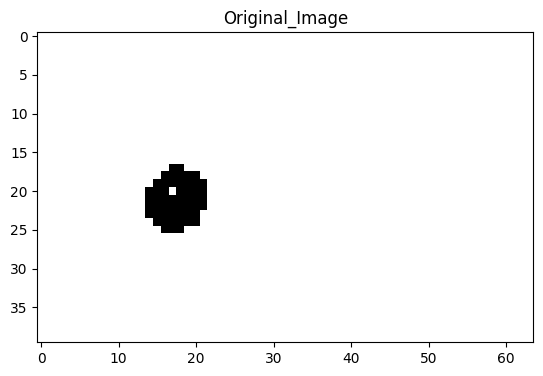

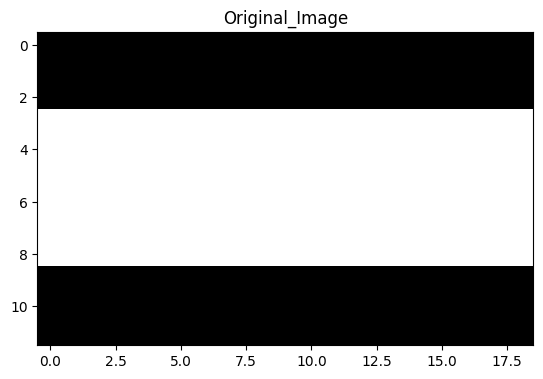

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


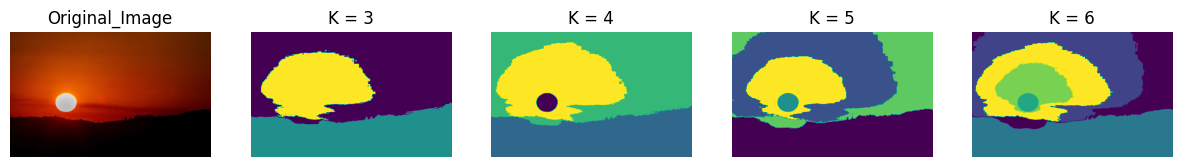

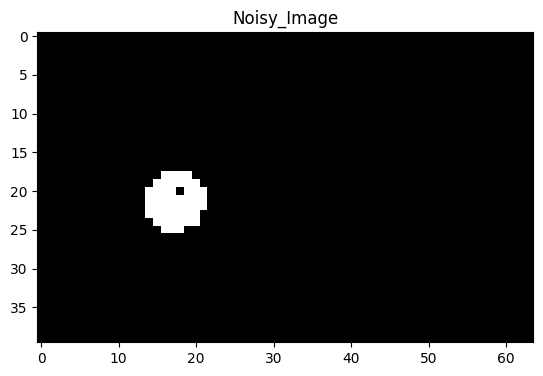

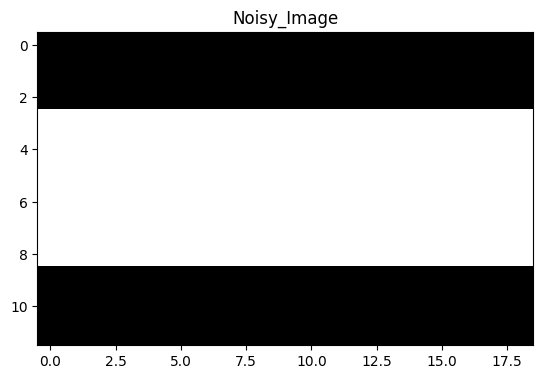

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


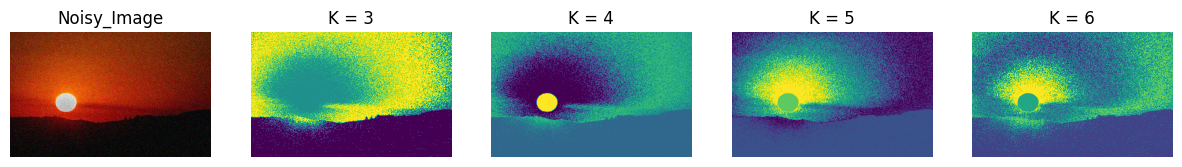

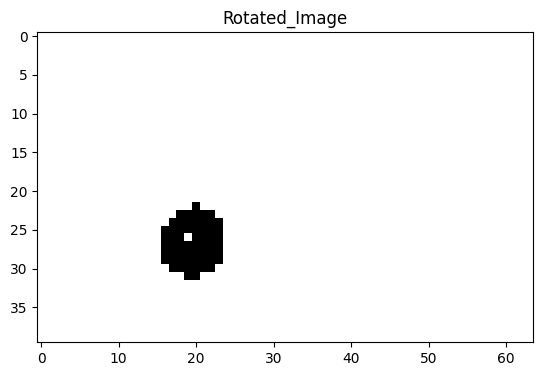

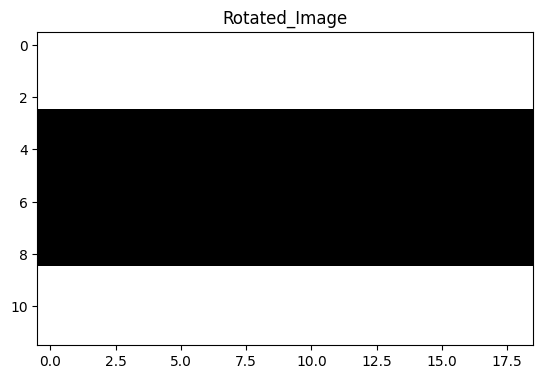

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


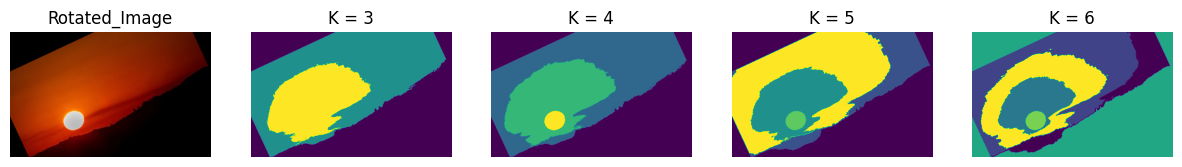

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


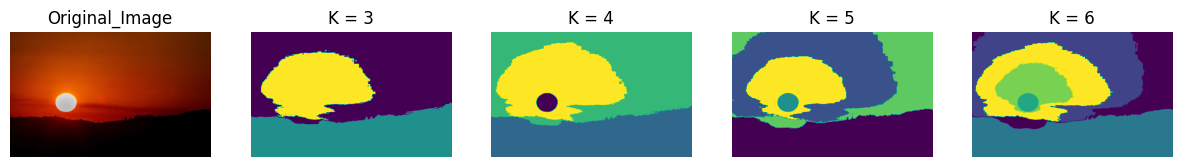

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


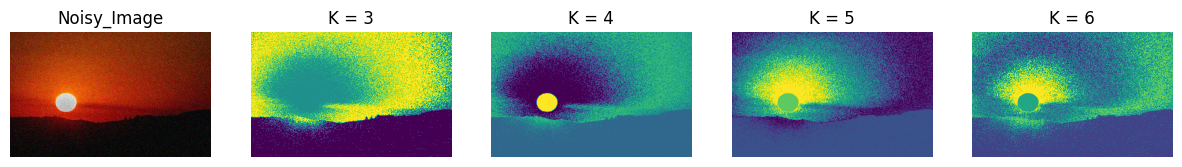

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


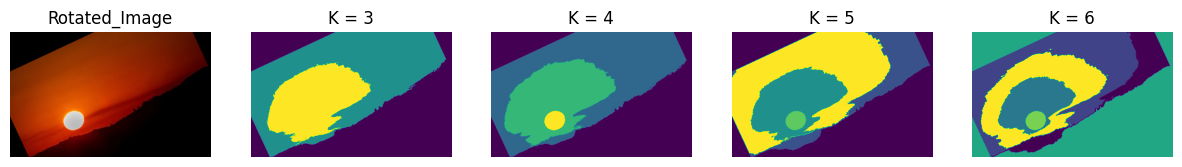

In [154]:
def main():
    image_path1 = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_1/img1.jpeg'
    image_path2 = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_1/img2.jpeg'
    image_path3 = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_1/img3.jpeg'
    image_path4 = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_1/img4.jpeg'
    image1 = skimage.io.imread(image_path1)
    image2 = skimage.io.imread(image_path2)
    image3 = skimage.io.imread(image_path3)
    image4 = skimage.io.imread(image_path4)

    image_original=image2
    NCut_UsingBrightness(image_original,'Original_Image')
    NCut_UsingDistance(image_original,'Original_Image')
    UsingKMeans(image_original,'Original_Image')


    image_noisy = skimage.util.random_noise(image2, mode='gaussian')
    NCut_UsingBrightness(image_noisy,'Noisy_Image')
    NCut_UsingDistance(image_noisy,'Noisy_Image')
    UsingKMeans(image_noisy,'Noisy_Image')


    image_rotated = skimage.transform.rotate(image2, 25)
    NCut_UsingBrightness(image_rotated,'Rotated_Image')
    NCut_UsingDistance(image_rotated,'Rotated_Image')
    UsingKMeans(image_rotated,'Rotated_Image')

    UsingKMeans(image_original,'Original_Image')
    UsingKMeans(image_noisy,'Noisy_Image')
    UsingKMeans(image_rotated,'Rotated_Image')
    return



if __name__ == '__main__':
    main()

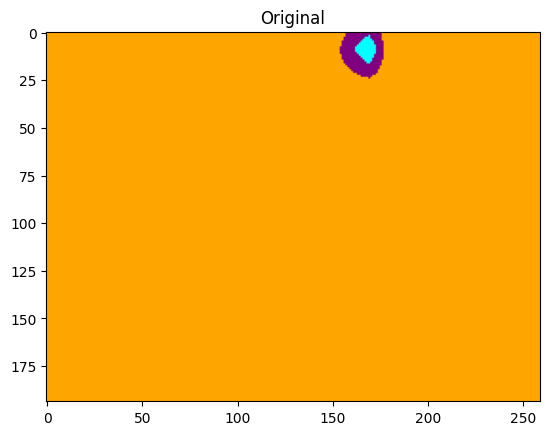

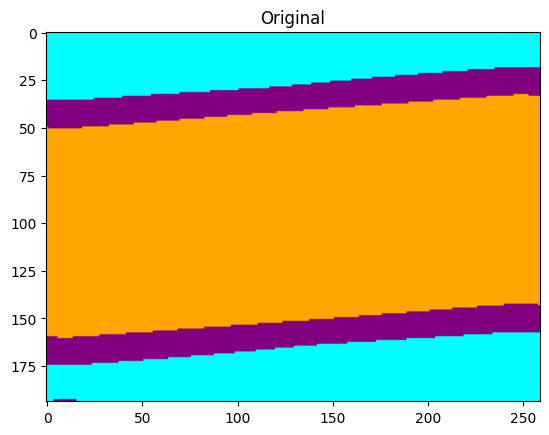

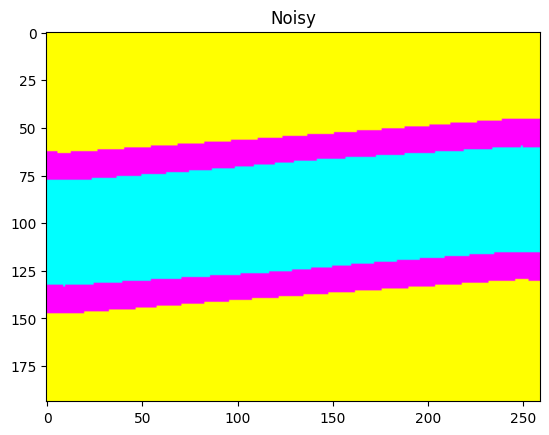

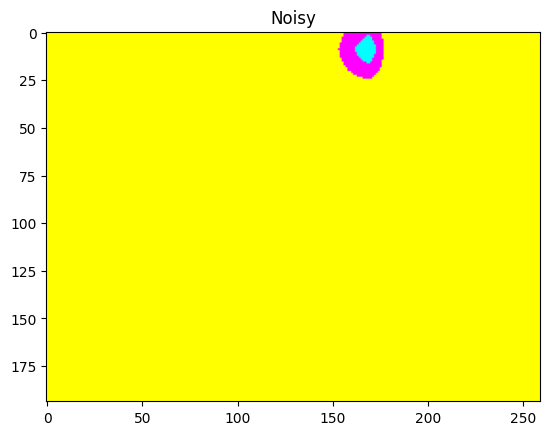

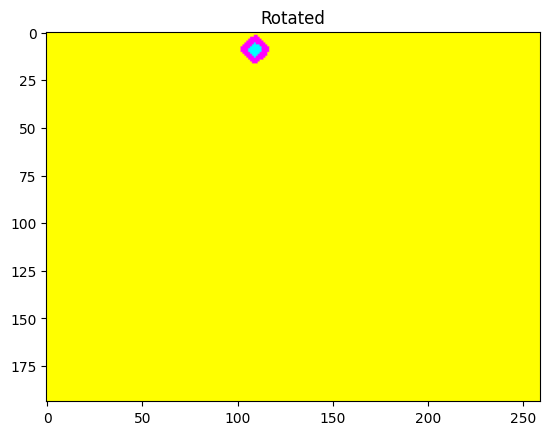

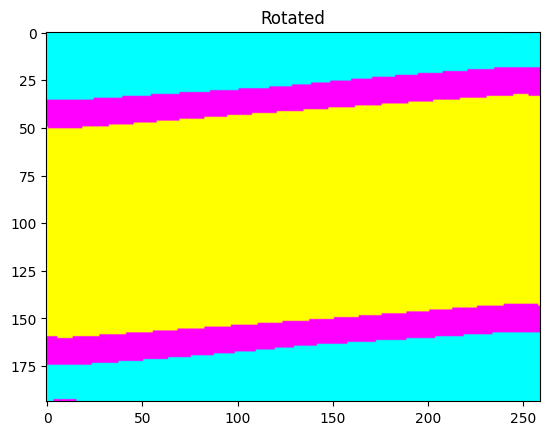

In [155]:
def main():
    image_path = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_1/img4.jpeg'
    image = skimage.io.imread(image_path)
    NCut_UsingBrightnessThreeSeg(image,'Original')
    NCut_UsingDistanceThreeSeg(image,'Original')

    image_noisy = skimage.util.random_noise(image, mode='gaussian')
    NCut_UsingDistanceThreeSeg(image_noisy,'Noisy')
    NCut_UsingBrightnessThreeSeg(image_noisy,'Noisy')

    image_rotated = skimage.transform.rotate(image, 45)
    NCut_UsingBrightnessThreeSeg(image_rotated,'Rotated')
    NCut_UsingDistanceThreeSeg(image_rotated,'Rotated')
    return



if __name__ == '__main__':
    main()